# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import data_loaders, prepare_submission, net

import matplotlib.pyplot as plt
import numpy as np
import torch                     
from torch.autograd import Variable

# Data

In [3]:
train_raw, train_keys_raw = data_loaders.training_images()
"""
test, test_keys = data_loaders.test_images()
masks = data_loaders.training_masks()
s_masks = data_loaders.single_masks(masks)
"""

'\ntest, test_keys = data_loaders.test_images()\nmasks = data_loaders.training_masks()\ns_masks = data_loaders.single_masks(masks)\n'

In [4]:
# For now, let us reduce our input data to just things that are 256x256
train, train_keys = [], []
for i in range(len(train_raw)):
    if train_raw[i].shape == (256, 256):
        train.append(train_raw[i])
        train_keys.append(train_keys_raw[i])
print(len(train), len(train_keys))

334 334


# UNET

In [8]:
n = net.u_net()
inp = Variable(torch.randn(1, 1, 572, 572))

n(inp).shape

torch.Size([1, 1, 388, 388])

# A really silly idea

Can we just have a cutoff and call everything > than that a cell?

6.0 9.41135663294 11.0322839506
454
558


(array([   1.,    0.,    1.,    0.,    2.,   10.,   24.,   43.,   45.,  544.]),
 array([ 0.15916748,  0.24302032,  0.32687317,  0.41072601,  0.49457886,
         0.5784317 ,  0.66228455,  0.74613739,  0.82999023,  0.91384308,
         0.99769592]),
 <a list of 10 Patch objects>)

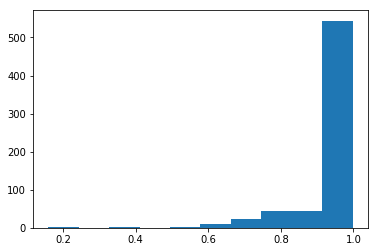

In [36]:
res = []

print(np.median(train[0]), np.std(train[0]), np.mean(train[0]))
for i in range(len(train)):
    score = np.sum((train[i] > np.median(train[i]) + np.std(train[i])) == (s_masks[i] == 255)) / np.prod(s_masks[i].shape)
    res.append(score)
    if score < 0.5:
        print(i)

plt.hist(res)

In [87]:
test_res = []
for i in range(len(test)):
    test_res.append(
        (test[i] > np.median(test[i]) + np.std(test[i])) |
        (test[i] < np.median(test[i]) - 3*np.std(test[i])))
test_res = [prepare_submission.separate_masks(i) for i in test_res]
test_res = [prepare_submission.remove_tiny_masks(i) for i in test_res]

In [88]:
prepare_submission.write_submission("test.out", test_res, test_keys)

65
